In [2]:
from scipy.signal import hilbert
%load_ext autoreload
%autoreload 2

import plots
import runner
import analysis
import processing
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out


# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise lead to synchronization across two networks

----

How can we replicate and extend with our current setup?

* two EI networks showing natural activity in gamma frequency band
* gamma produced by PING mechanism
* input noise also as Poisson Group per neuron
* compute local and global order parameter for one run
* parameter exploration with noise strength
* collect results and compare local and global order parameters
* generate plots for specific configurations as visual proof

## Model Configuration

In [3]:
# overwriting default parameters
params = {
  # synaptic coupling strengths, most important parameters for tuning PING mechanism
  "J_itoi": 3.,
  "J_etoe": .1,
  "J_etoi": .5,
  "J_itoe": 10.,

  # Independent spike trains generated by Poisson Point Process for each target neuron
  "ext_input_type": "poisson",
  # in mV, influence of a pre synaptic spike
  # TODO: set it in the same ways as Meng et al. does it or argue why we should it differently
  "poisson_strengths": [1., 3.],
  # 50 Hz rate as in Meng et. al. and decreasing with network index
  "poisson_rates": [50, 30],

  "J_ppee": 0.0,
  # increase from 0.1 to 0.2 increases mainly amplitude
  "J_ppei": 0.0,

  # if set to default of 0.1 this leads to strange split in frequency band
  "const_delay": 0.2,
  "N_pop": 2
}

pprint(params)

{'J_etoe': 0.1,
 'J_etoi': 0.5,
 'J_itoe': 10.0,
 'J_itoi': 3.0,
 'J_ppee': 0.0,
 'J_ppei': 0.0,
 'N_pop': 2,
 'const_delay': 0.2,
 'ext_input_type': 'poisson',
 'poisson_rates': [50, 30],
 'poisson_strengths': [1.0, 3.0]}


In [4]:
model = runner.run(modified_params=params, file_name="meng-replication")

Initializing net ...
initialization time: 0.6490778923034668s
------------------ running network!
runtime: 30.0


INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


In [5]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("meng-replication")


## Model Visualization

Generate PSD plot ...
Generate PSD plot ...


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131deefd0>)

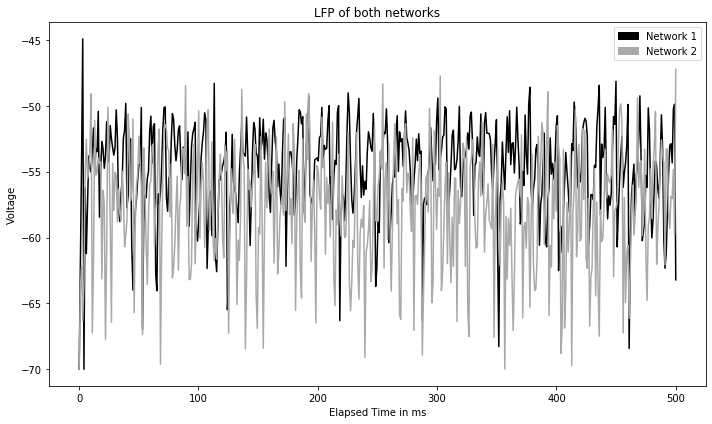

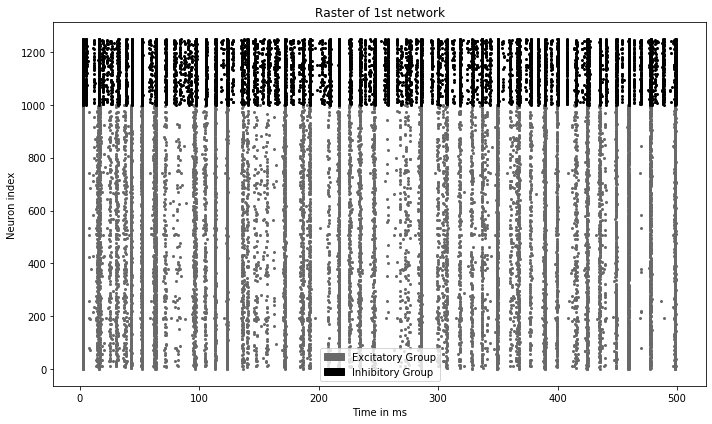

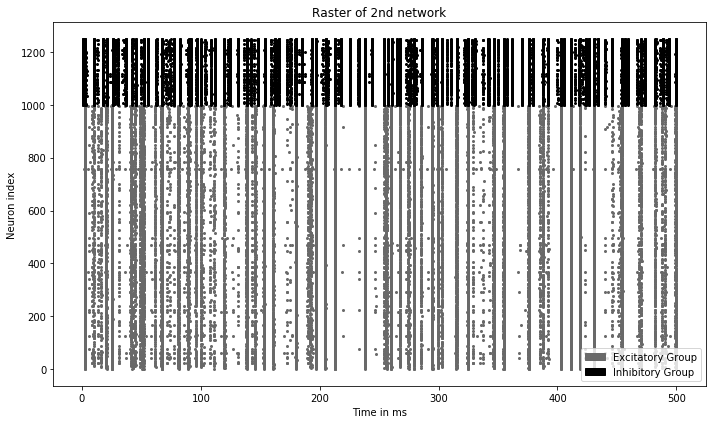

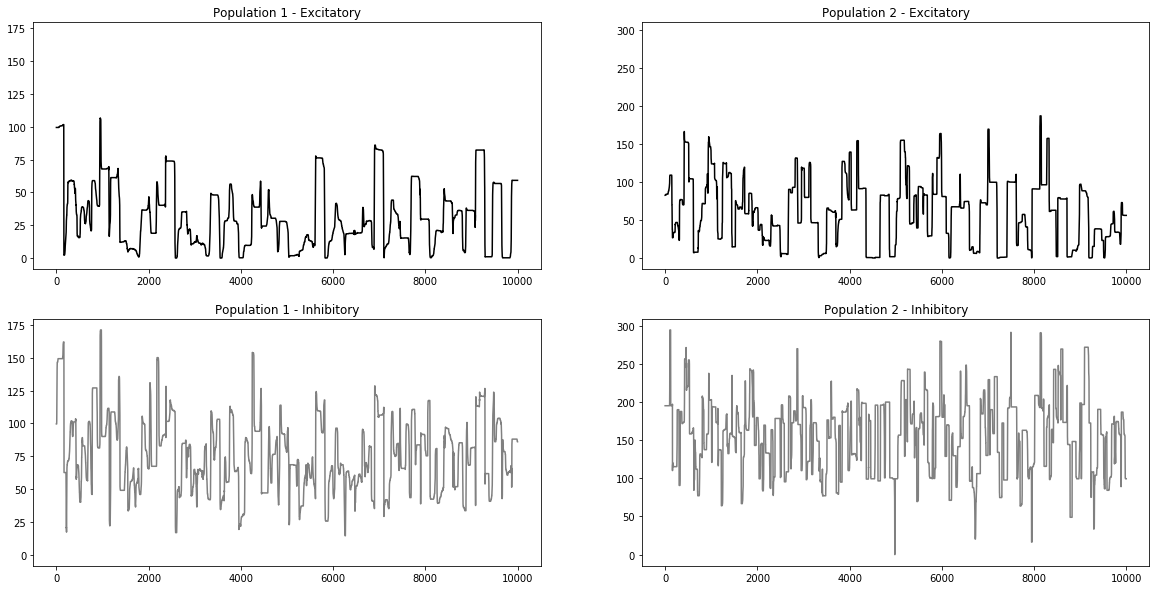

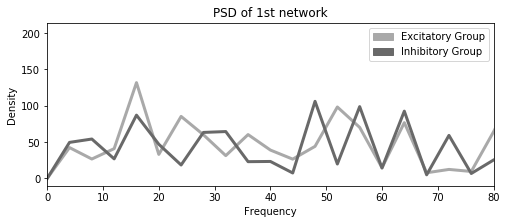

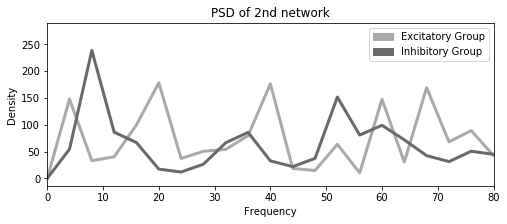

In [6]:
plots.lfp_nets(model)

plots.raster(title="Raster of 1st network", model=model)
plots.raster(title="Raster of 2nd network", model=model, population=2)

plots.population_rates(model)

plots.psd(model, title="PSD of 1st network")
plots.psd(model, title="PSD of 2nd network", population=2)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1320be860>)

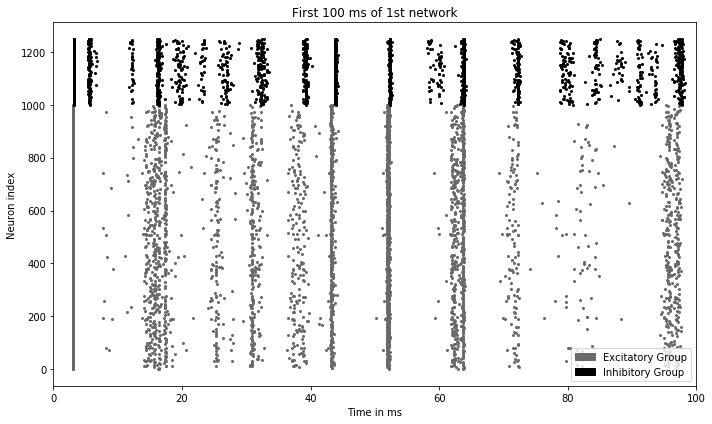

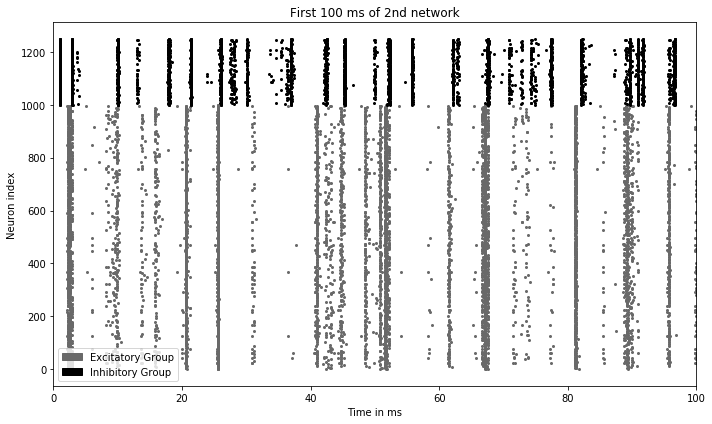

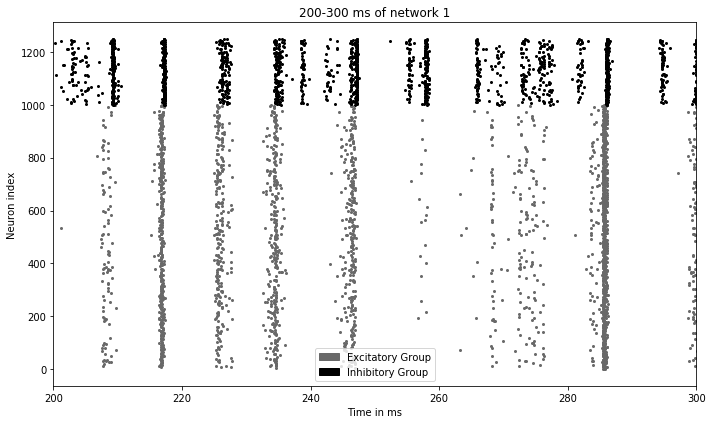

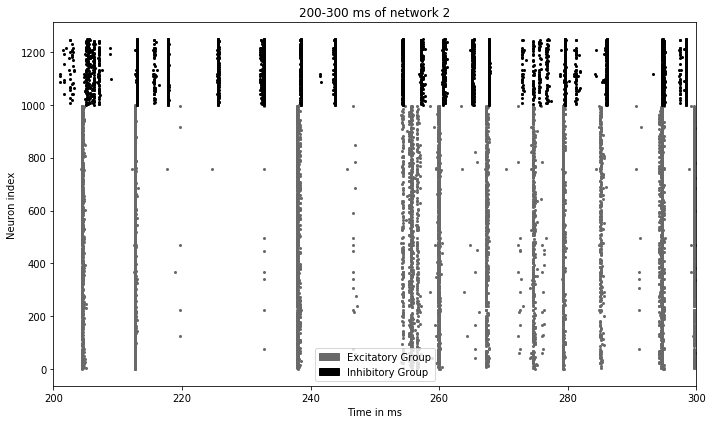

In [7]:
plots.raster(title="First 100 ms of 1st network", model=model, x_left=0, x_right=100)
plots.raster(title="First 100 ms of 2nd network", model=model, x_left=0, x_right=100, population=2)

plots.raster(title="200-300 ms of network 1", model=model, x_left=200, x_right=300)
plots.raster(title="200-300 ms of network 2", model=model, x_left=200, x_right=300, population=2)


## Synchronization Analysis

In [8]:
neurons_e = model['model_results']['net']['v_all_neurons_e']
neurons_i = model['model_results']['net']['v_all_neurons_i1']

signals = [s - np.mean(s) for s in neurons_e]

# phases.extend([processing.phase(neuron) for neuron in neurons_i])

# compute analytical signal and take angle to get phase
phases = [np.angle(hilbert(s)) for s in signals]

# transform to complex phase to prepare for averaging
complex_phase = [np.exp(1j * phase) for phase in phases]

# take the average (sum up all complex phases and divide by number of phases)
# average over each time point
# afterwards we have a vector of (1, #neurons), each entry is the average complex phase at a timepoint
avg = np.average(complex_phase, axis=1)

# length of complex number
phi = np.abs(avg)

# average of length if we have an array
local_order_parameter = np.mean(phi)


pprint(local_order_parameter)
print(f"Local order of {local_order_parameter}")


0.11588434100805534
Local order of 0.11588434100805534


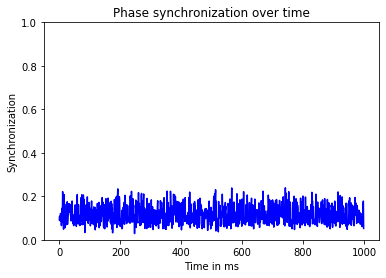

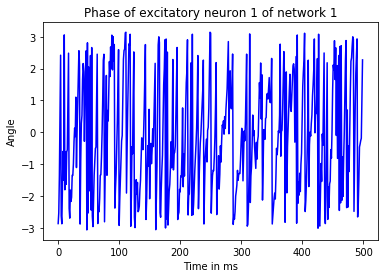

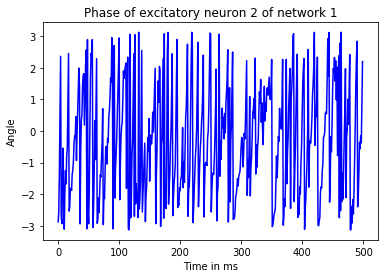

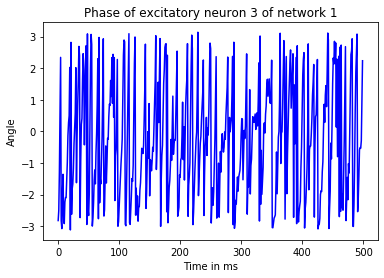

In [18]:
plt.title(f"Phase synchronization over time")
plt.xlabel("Time in ms")
plt.ylim(0, 1)
plt.ylabel("Synchronization")
plt.plot(phi, c="blue")
plt.show()

for idx, phase in enumerate(phases[:3]):
    plt.title(f"Phase of excitatory neuron {idx + 1} of network 1")
    plt.xlabel("Time in ms")
    plt.ylabel("Angle")
    plt.plot(phase, c="blue")
    plt.show()

WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


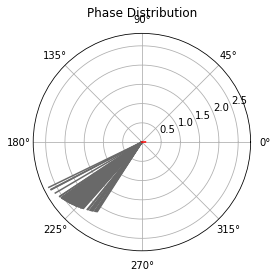

In [19]:
plt.axes(polar=True)
plt.title("Phase Distribution")

for angle in phases[:100]:
    plt.plot((0, angle[1]), (0, np.abs(angle[1])), c="dimgrey")

# plot the average phase vector
# length of vector expresses the consistency
plt.plot((0, avg[0]), (0, phi[0]), c='red')

plt.show()

In [11]:
# the lower the PLV the lower the phase consistency or phase locking is

plv_e = processing.phase_locking_value(neurons_e)
print(f"PLV of excitatory group {plv_e}")

plv_i = processing.phase_locking_value(neurons_i)
print(f"PLV of inhibitory group {plv_i}")

all_neurons = np.vstack((neurons_e, neurons_i))
plv_all = processing.phase_locking_value(all_neurons)
print(f"PLV of network 1 {plv_all}")


PLV of excitatory group 0.10956101178705593
PLV of inhibitory group 0.17046326245566193
PLV of network 1 0.11733924013602051
